## To-do list
- metrics functions
- check for directories structure (model for prediction, databases, saving directory for the drawdown/VaR/etc plots, backup directory for model, backup directory for plots)
- import metrics (VaR, cVaR, drawdown, etc.) functions from metrics module
- Copy keys.py explanation from Touring
- Two main fund strategies: (1) passive - trade on 1st of each month, keep in basked the 10 crytpos with the most market cap; (2) active - trade every week based on predicted returns for the next week
- Let the user define how many assets to invest into
- Tem que usar sentiment analysis de twitter, reddit, google news, etc. Trabalhar com dados em T+0 e em T-1, T-2, T-3...
- Faz defasagem para RSI também
- Ver se tem algum dado de taxa de juros americana/europeia/chinesa(?)/japonesa diária
- Ou algum dado 'mundial' para ajudar na intepretação dos dados
- Também trabalhar com defasagens (1, 2, 3...) nesses dados
- When using Markovwitz, use pypfopt package
- Ao invés do clustering normal tenta filtrar por rsi > X, usa tipo as 10 maiores coins. Para isso de repente vale a pena utilizar 20 coins no total (por enquanto tá com as 15 mais líquidas) 


In [1]:
#------ Import basic packages
#import matplotlib.pyplot as plt
#import seaborn as sns
#import smtplib  # Needed for the e-mail reports
#import binance.enums  # Responsible for trading

import numpy as np
import pandas as pd
#import pandas_ta
from functions import *
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.8f' % x)

In [2]:
#from metrics import mvcriterion, optim_mvcrit

#wallet = binance_wallet()

# fetch_data() checks for the most liquid cryptos and fetches the data from Binance
data = fetch_data(days=365*3, interval='1w')
#data.drop('cluster_num', axis=1, inplace=True)

# Let's calculate the technical indicators
data = estimate_indicators(data, rsi=20, bbands=20, roll=13, resample=False)

# After the indicators are calculated, perform the normalization of the values
print('Normalizing the "close" values...')
normalized_close = data.groupby(level='asset')['close'].apply(lambda x:
                                                              np.subtract(x, data.groupby(level='asset')['close'].mean())/data.groupby(level='asset')['close'].std()
                                                              )

# Register the normalized close into the df
data['close_norm'] = np.array(normalized_close)
print('"close" values normalized and added to the dataframe.')

# Now we need to estimate the optimal number of clusters to
# allocate our resources
print('Estimating the proper number of clusters in the data...')
clust = estimate_kmeans(data.drop('close', axis=1), cutoff=0.125)

# Sets the params for the clustering function used with apply below
params2 = {'clusters':clust,
           'means':1,
           'metric':'rsi'}

# Groups the data and applies the clustering
data = data.dropna().groupby('time', group_keys=False).apply(clustering, **params2)
print('Clustering done.')

# Filters the specific RSI range for the passive portfolios (you may choose the higher band or the lower band from any indicator,
# we're going with low RSI for now)
#filtered_data, dates_dict = filter_dates_and_assets(data, metric='rsi', profile='low')

#############3 PAREI EM 1:31:39 DO VIDEO

#############
## Só para deixar anotado aqui
#############
"""
Para estiamr o VaR (value at risk) pelo método histórico basta ordenar todos os rendimentos ao longo do período em ordem crescente. Uma série de retornos
vai ter um VaR X com nível de confiança de 95% no percentil 5 (vai ser esse percentual pelo que eu entendi).

Pelo método Variância-Covariância, calcula a média e o desvio padrão gerais, soma todos os retornos de cada ativo, o peso de cada ativo (proporção do total),
o desvio padrão de cada ativo e o índice de correlação entre eles. Usando o z-score, se calcula o intervalo de confiança (VaR = média + z*std). Pode, então
se ajustar o VaR pelo horizonte de tempo: se o VaR é calculado com retornos diários, então o VaR para T dias é VaR_diário*T^(1/2).

Tem estimação por Monte Carlo também se precisar, mas não vou descrever aqui.

ES (expected shortfall) é a média dos retornos negativos excedentes ao VaR. Ou seja, Com um VaR a 95% de confiança pelo método histórico, a ES é a média
dos outros 5%.

AGORA QUE VI QUE TEM ATÉ CÓDIGO PRONTO PRA ISSO:

returns = np.random(blablabla)
confidence_level = 0.95

# VaR
sorted_returns = np.sort(returns)
VaR = sorted_returns[int((1 - confidence_level) * len(sorted_returns))]

# ES
ES = np.mean(sorted_returns[sorted_returns <= VaR])

print(f'VaR ({confidence_level*100}%): {VaR:.4f}')
print(f'Expected Shortfall (ES) ({confidence_level*100}%): {ES.4f}')

### Testa se os retornos são calculados certos: (p - p_-1)/p_-1
"""

Checking for trading pairs...
The resources directory exists, checking for trade pairs file.
Trading pairs file 'pairs_202508.csv' found, checking version.
Trading pairs file is up to date.
Loading pairs.
Pairs successfully loaded.
Requesting data from Binance.
Data downloaded.
Calculating RSI (momentum).
Calculating Bollinger Bands (vol).
Calculating ATR (vol).
Calculating MACD (momentum).
Calculating dollar volume in millions.
Creating dollar volume moving averages.
Checking cryptos liquidity.
Creating a rank for the best cryptos in the dataset.
Estimating returns.
All indicators successfuly calculated.
Normalizing the "close" values...
"close" values normalized and added to the dataframe.
Estimating the proper number of clusters in the data...
Clustering done.


"\nPara estiamr o VaR (value at risk) pelo método histórico basta ordenar todos os rendimentos ao longo do período em ordem crescente. Uma série de retornos\nvai ter um VaR X com nível de confiança de 95% no percentil 5 (vai ser esse percentual pelo que eu entendi).\n\nPelo método Variância-Covariância, calcula a média e o desvio padrão gerais, soma todos os retornos de cada ativo, o peso de cada ativo (proporção do total),\no desvio padrão de cada ativo e o índice de correlação entre eles. Usando o z-score, se calcula o intervalo de confiança (VaR = média + z*std). Pode, então\nse ajustar o VaR pelo horizonte de tempo: se o VaR é calculado com retornos diários, então o VaR para T dias é VaR_diário*T^(1/2).\n\nTem estimação por Monte Carlo também se precisar, mas não vou descrever aqui.\n\nES (expected shortfall) é a média dos retornos negativos excedentes ao VaR. Ou seja, Com um VaR a 95% de confiança pelo método histórico, a ES é a média\ndos outros 5%.\n\nAGORA QUE VI QUE TEM ATÉ CÓ

In [10]:
def optimize_basket(prices, freq=30, l_bound=0.0, h_bound=1.0):
    """
    Description: optimize the weights of each asset for each period

    Input:  prices (pandas Series), the Series containing the assets prices;
            freq (int), the frequency on which to perform historical returns. Defaults to 30 (a month, based on daily observations);
            l_bound (float), the lower bound for each minimum asset allocation. Defaults to 0;
            h_bound (float), the higher bound for each maximum asset allocation. Defaults to 1.
        
    Outputs: --- to be seen ---
             df_temp (pandas DataFrame): filtered original df;
             dates_dict (dict): dictionary containing each asset for each day of trading.
    """
    from pypfopt import risk_models, expected_returns
    from pypfopt.efficient_frontier import EfficientFrontier

    rend = expected_returns.mean_historical_return(prices=prices, frequency=freq)

    cov_matrix = risk_models.sample_cov(prices=prices, frequency=freq)

    ef = EfficientFrontier(expected_returns=rend,
                           cov_matrix=cov_matrix,
                           weight_bounds=(l_bound, h_bound),
                           solver='SCS')
    
    try:
        weights = ef.max_sharpe()
        return ef.clean_weights()
    
    except ValueError:
        print('ERROR! All the calculated returns are negative. At least one of them MUST be positive.')



In [24]:
optimize_basket(data[data.cluster_num == 2]['close_norm'], freq=4, l_bound=0.0, h_bound=1.0)

OrderedDict([('close_norm', 1.0)])

In [20]:
data['cluster_num'].value_counts()

cluster_num
0    1470
3     219
2     135
1     115
Name: count, dtype: int64

### Down here are the tweaked old functions (clustering, mostly):

In [6]:
data.drop('cluster_num', axis=1, inplace=True)
clust = estimate_kmeans(data.drop('close', axis=1), cutoff=0.125)

# Sets the params for the clustering function used with apply below
params2 = {'clusters':clust,
           'means':1,
           'metric':'rsi'}

# Groups the data and applies the clustering
data = data.dropna().groupby('time', group_keys=False).apply(clustering, **params2)

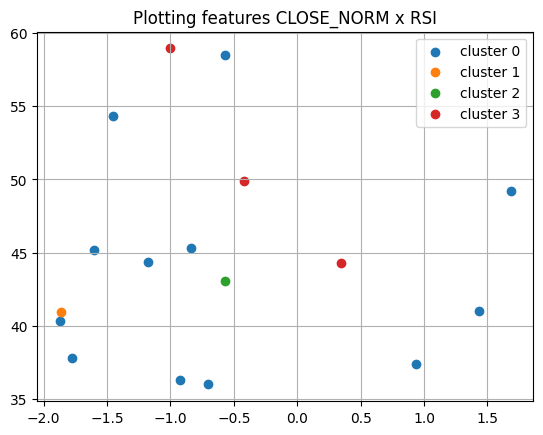

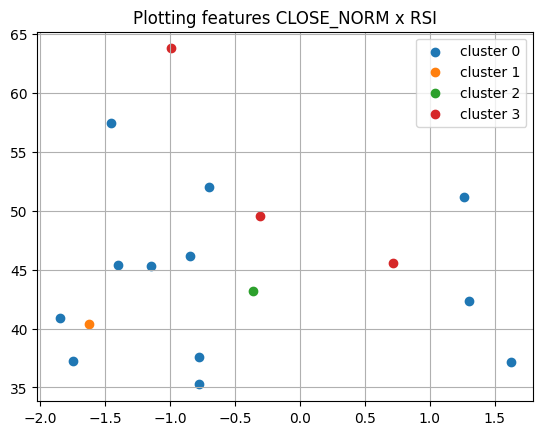

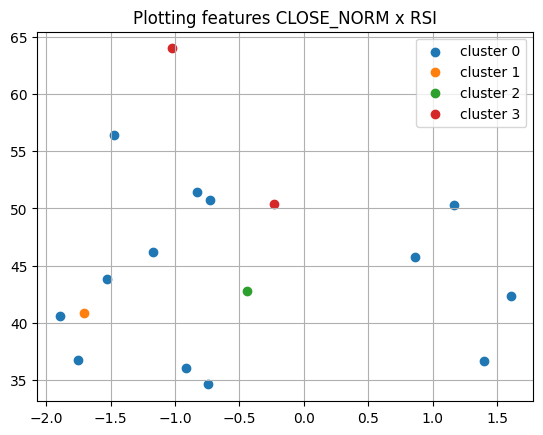

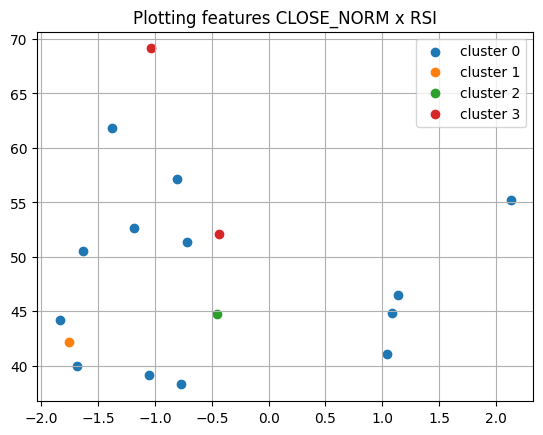

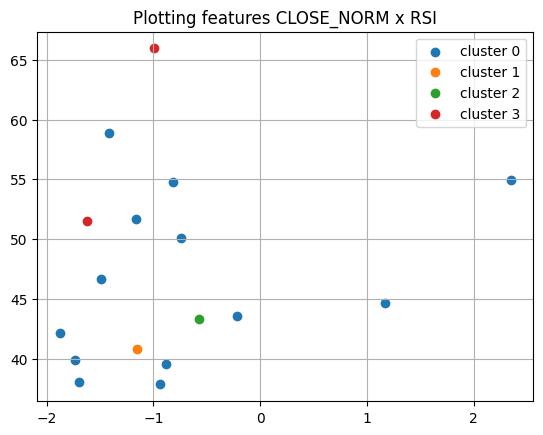

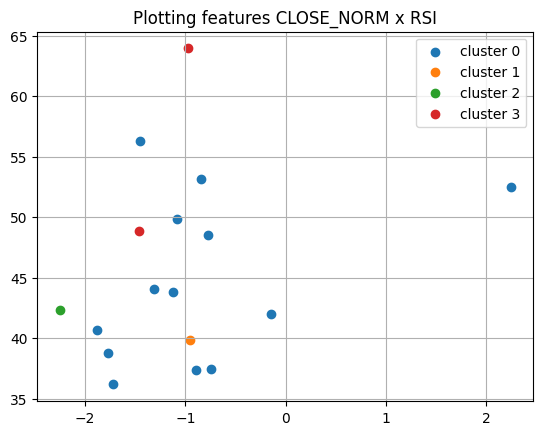

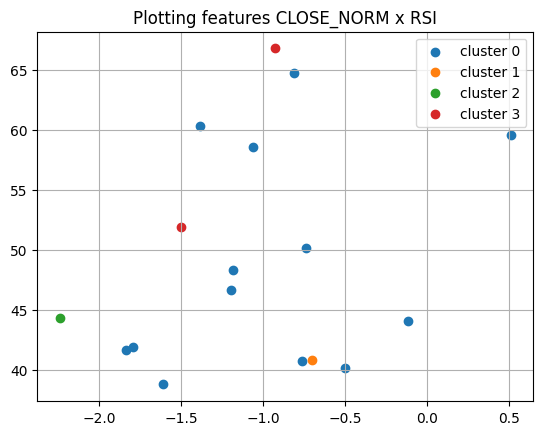

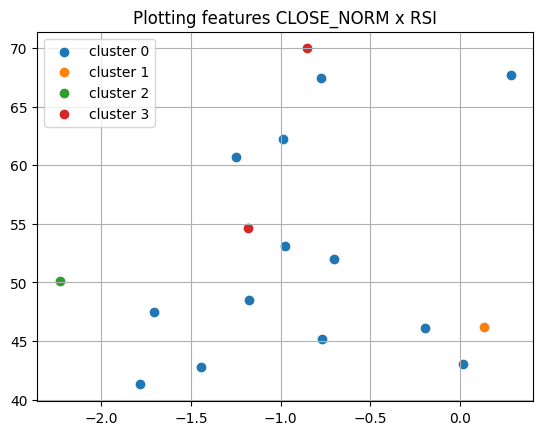

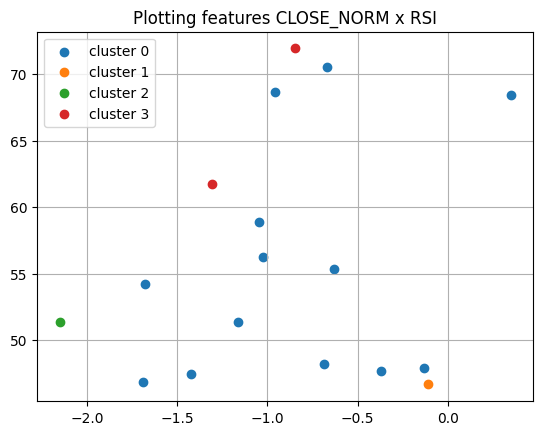

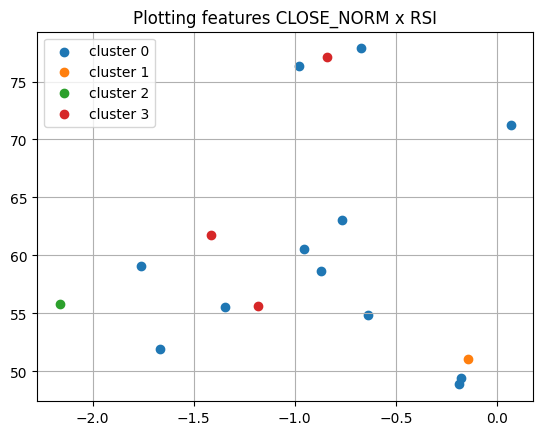

In [7]:
# Prints the clustering graph
times = data.index.get_level_values('time').unique().to_list()[0:10]
for t in times:
    g = data.xs(t, level=1)
    plot_clusters(g)